<a href="https://colab.research.google.com/github/monicalamagt/monicalamagt.github.io/blob/main/phase1_factor_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ta
!pip install catboost
!pip install quantstats
import warnings
import quantstats as qs
from catboost import CatBoostClassifier, CatBoostRegressor
import os
import requests
import pandas as pd
from datetime import datetime
import time
from google.colab import userdata
import ta
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=5d721f8a15206c15775644bbb01fda8f001c67a95d4446d7355a58ead7c5eb95
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_data_path = '/content/drive/MyDrive/crypto_momentum_data'
os.makedirs(drive_data_path, exist_ok=True)

Mounted at /content/drive


In [ ]:
API_KEY = userdata.get('COIN_GECKO_API')
headers = {'x-cg-pro-api-key': API_KEY}

**Data Source Summary**

We use CoinGecko Pro API to collect daily OHLCV data for the top 100 cryptocurrencies by market cap. The data spans January 2024 to December 2024, and is downloaded once and stored locally as .csv to minimize API calls. API keys are loaded via Colab secrets.


In [ ]:
#get top 100 coins from GECKO and download OHLCV information from the past to csv.

os.makedirs('data', exist_ok=True)

def get_top_100_coins():
    url = 'https://pro-api.coingecko.com/api/v3/coins/markets'
    params = {
        'vs_currency': 'usd',
        'order': 'market_cap_desc',
        'per_page': 100,
        'page': 1,
        'sparkline': False
    }
    response = requests.get(url, headers=headers, params=params)

    try:
        data = response.json()
        if not isinstance(data, list):
            print("Unexpected response:", data)
            return None
    except Exception as e:
        print("Failed to decode JSON:", e)
        return None

    coins = [{'id': coin['id'], 'symbol': coin['symbol'], 'name': coin['name']} for coin in data]
    return pd.DataFrame(coins)

def get_ohlcv(coin_id, start_date, end_date):
    url = f'https://pro-api.coingecko.com/api/v3/coins/{coin_id}/market_chart/range'
    params = {
        'vs_currency': 'usd',
        'from': int(datetime.strptime(start_date, '%Y-%m-%d').timestamp()),
        'to': int(datetime.strptime(end_date, '%Y-%m-%d').timestamp())
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code != 200:
        print(f"Error fetching {coin_id}: {response.status_code} {response.text}")
        return None
    data = response.json()

    prices = data.get('prices', [])
    volumes = data.get('total_volumes', [])

    if not prices or not volumes:
        print(f"No data for {coin_id}. Skipping.")
        return None

    df = pd.DataFrame({
        'timestamp': [x[0] for x in prices],
        'price': [x[1] for x in prices],
        'volume': [x[1] for x in volumes],
    })
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('date', inplace=True)
    df.drop('timestamp', axis=1, inplace=True)
    return df

def download_all_coins(top_100_df, start_date, end_date, save_dir):
    for idx, row in top_100_df.iterrows():
        coin_id = row['id']
        save_path = os.path.join(save_dir, f"{coin_id}.csv")

        if os.path.exists(save_path):
            print(f"Already downloaded {coin_id}, skipping...")
            continue

        print(f"Downloading {coin_id}...")
        df = get_ohlcv(coin_id, start_date, end_date)
        if df is not None:
            df.to_csv(save_path)
            print(f"Saved {coin_id} to {save_path}")
        time.sleep(1.5)



top_100_df = get_top_100_coins()
download_all_coins(top_100_df, '2024-01-01', '2024-12-31', save_dir=drive_data_path)

Saved bitcoin to /content/drive/MyDrive/crypto_momentum_data/bitcoin.csv
Saved ethereum to /content/drive/MyDrive/crypto_momentum_data/ethereum.csv
Saved tether to /content/drive/MyDrive/crypto_momentum_data/tether.csv
Saved ripple to /content/drive/MyDrive/crypto_momentum_data/ripple.csv
Saved binancecoin to /content/drive/MyDrive/crypto_momentum_data/binancecoin.csv
Saved solana to /content/drive/MyDrive/crypto_momentum_data/solana.csv
Saved usd-coin to /content/drive/MyDrive/crypto_momentum_data/usd-coin.csv
Saved tron to /content/drive/MyDrive/crypto_momentum_data/tron.csv
Saved dogecoin to /content/drive/MyDrive/crypto_momentum_data/dogecoin.csv
Saved staked-ether to /content/drive/MyDrive/crypto_momentum_data/staked-ether.csv
Saved cardano to /content/drive/MyDrive/crypto_momentum_data/cardano.csv
Saved wrapped-bitcoin to /content/drive/MyDrive/crypto_momentum_data/wrapped-bitcoin.csv
Saved hyperliquid to /content/drive/MyDrive/crypto_momentum_data/hyperliquid.csv
Saved wrapped-s

**Feature Engineering Approach**

We compute the momentum-based and and volatility-based features for each crypto currency. We create a method for each feature, and apply it to the price and volume data read from csv files.

The following features are calculated:
1. Momentum: 1D, 3D, 7D Returns
2. Volatility: 14-Day Volatility
3. Volume: 30-Day Z-Score
4. Technicals: RSI (14-Day), MACD (12/26/9), Bollinger Bands (20-Day)

In [ ]:
def add_returns(df):
    df['return_1d'] = df['price'].pct_change(1)
    df['return_3d'] = df['price'].pct_change(3)
    df['return_7d'] = df['price'].pct_change(7)
    return df

def add_volume_zscore(df, window=30):
    rolling_mean = df['volume'].rolling(window=window).mean()
    rolling_std = df['volume'].rolling(window=window).std()
    df['volume_zscore'] = (df['volume'] - rolling_mean) / rolling_std
    return df

def add_volatility(df, window=14):
    if 'return_1d' not in df.columns:
        df['return_1d'] = df['price'].pct_change(1)
    df['volatility_14d'] = df['return_1d'].rolling(window).std()
    return df

def add_rsi(df, window=14):
    rsi_series = ta.momentum.RSIIndicator(close=df['price'], window=window).rsi()
    df['rsi_14d'] = rsi_series
    return df

def add_macd(df):
    macd = ta.trend.MACD(close=df['price'], window_slow=26, window_fast=12, window_sign=9)
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = macd.macd_diff()
    return df

def add_bollinger_bands(df, window=20, std=2):
    bb = ta.volatility.BollingerBands(close=df['price'], window=window, window_dev=std)
    df['bb_bbm'] = bb.bollinger_mavg()
    df['bb_bbh'] = bb.bollinger_hband()
    df['bb_bbl'] = bb.bollinger_lband()
    df['bb_width'] = (df['bb_bbh'] - df['bb_bbl']) / df['bb_bbm']
    return df


In [ ]:
#this method is for both feature engineering and target labeling (explained below).

def process_all_coins(data_dir='data', horizon=1, classification=False, base_col='price'):
    all_dfs = []

    for filename in os.listdir(data_dir):
        if not filename.endswith('.csv'):
            continue

        coin_id = filename.replace('.csv', '')
        filepath = os.path.join(data_dir, filename)
        df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')

        df = add_returns(df)
        df = add_volume_zscore(df)
        df = add_volatility(df)
        df = add_rsi(df)
        df = add_macd(df)
        df = add_bollinger_bands(df)

        df = add_target(df, horizon=horizon, classification=classification, base_col=base_col)

        df['symbol'] = coin_id
        df = df.dropna()
        all_dfs.append(df)

    combined_df = pd.concat(all_dfs)
    return combined_df


In [ ]:
# Single-Coin (Bitcoin (BTC)) Modeling Exploration - Preliminary Results

btc_df = pd.read_csv(os.path.join(drive_data_path, 'bitcoin.csv'), parse_dates=['date'], index_col='date')

btc_df = add_returns(btc_df)
btc_df = add_volume_zscore(btc_df)
btc_df = add_volatility(btc_df)
display(btc_df[['price', 'return_1d', 'volume', 'volume_zscore', 'volatility_14d']].dropna().head())

btc_df = add_rsi(btc_df)
display(btc_df[['price', 'rsi_14d']].dropna().head())

btc_df = add_macd(btc_df)
display(btc_df[['macd', 'macd_signal', 'macd_diff']].dropna().head())

btc_df = add_bollinger_bands(btc_df)
display(btc_df[['price', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_width']].dropna().head())


,price,return_1d,volume,volume_zscore,volatility_14d
date,,,,,
2024-01-30,43267.609276,0.029530,2.068032e+10,-0.369226,0.023634
2024-01-31,42892.034530,-0.008680,2.452666e+10,-0.087329,0.023518
2024-02-01,42583.263547,-0.007199,2.219794e+10,-0.294872,0.023437
2024-02-02,43069.043421,0.011408,2.244368e+10,-0.233591,0.021419
2024-02-03,43170.658562,0.002359,1.862479e+10,-0.505838,0.021372


,price,rsi_14d
date,,
2024-01-14,42848.474516,45.230748
2024-01-15,41800.932822,40.535446
2024-01-16,42587.336038,45.139576
2024-01-17,43148.001643,48.217887
2024-01-18,42713.859187,46.062554


,macd,macd_signal,macd_diff
date,,,
2024-02-03,-13.538446,-347.462721,333.924276
2024-02-04,35.899474,-270.790282,306.689756
2024-02-05,44.110747,-207.810076,251.920823
2024-02-06,53.957960,-155.456469,209.414429
2024-02-07,96.104414,-105.144293,201.248706


,price,bb_bbm,bb_bbh,bb_bbl,bb_width
date,,,,,
2024-01-20,41600.940933,43759.296450,47072.387970,40446.204930,0.151423
2024-01-21,41626.107110,43730.191697,47106.892414,40353.490980,0.154433
2024-01-22,41541.899457,43598.852610,47099.192293,40098.512928,0.160570
2024-01-23,39504.730058,43324.355419,47186.179800,39462.531038,0.178275
2024-01-24,39833.454105,43174.950175,47323.578549,39026.321801,0.192178


**Target Variable Labeling**

1. Below is a 1D and 7D forward return method for both binary and regression. Binary classification: target is 1 if the forward return is positive, 0 otherwise. Regression: The target is a percent return over the forward horizon.

2. I added binary volatility labeling where the model has a value of 1 if volitility will increase in next 7 days, 0 otherwise. *This allows us to explore risk forecasting and potential position-sizing enhancements in future iterations. Although this label is not used in model training yet, it provides a foundation for volatility-aware strategies.

In [ ]:
def add_target(df, horizon=1, classification=False, base_col='price'):
    if base_col not in df.columns:
        raise ValueError(f"'{base_col}' not found in DataFrame columns.")

    forward_change = df[base_col].pct_change(periods=horizon).shift(-horizon)

    if classification:
        df[f'target_class_{horizon}d'] = (forward_change > 0).astype(int)
    else:
        df[f'target_return_{horizon}d'] = forward_change

    return df

def add_volatility_label(df, future_window):
    past_vol = df['return_1d'].rolling(14).std()
    future_vol = df['return_1d'].rolling(future_window).std().shift(-future_window)
    df['vol_label'] = (future_vol > past_vol).astype(int)
    return df


In [ ]:
#run for all coins
multi_df = process_all_coins(data_dir=drive_data_path, horizon=1, classification=False, base_col='price')
multi_df.head()

,price,volume,return_1d,return_3d,return_7d,volume_zscore,volatility_14d,rsi_14d,macd,macd_signal,macd_diff,bb_bbm,bb_bbh,bb_bbl,bb_width,target_return_1d,symbol
date,,,,,,,,,,,,,,,,,
2024-02-03,43170.658562,1.862479e+10,0.002359,0.006496,0.031238,-0.505838,0.021372,55.036680,-13.538446,-347.462721,333.924276,41833.617383,44144.214056,39523.020709,0.110466,-0.004489,bitcoin
2024-02-04,42976.848300,7.779819e+09,-0.004489,0.009243,0.020352,-1.356855,0.021457,53.692348,35.899474,-270.790282,306.689756,41892.413157,44255.929804,39528.896509,0.112837,-0.008784,bitcoin
2024-02-05,42599.359971,1.125081e+10,-0.008784,-0.010905,0.013629,-0.997242,0.021642,51.075500,44.110747,-207.810076,251.920823,41893.014353,44257.243762,39528.784945,0.112870,0.001153,bitcoin
2024-02-06,42648.456921,1.868228e+10,0.001153,-0.012096,-0.014310,-0.400314,0.015940,51.407221,53.957960,-155.456469,209.414429,41868.037117,44188.861393,39547.212841,0.110864,0.010301,bitcoin
2024-02-07,43087.787408,1.713111e+10,0.010301,0.002581,0.004564,-0.539307,0.015974,54.387472,96.104414,-105.144293,201.248706,41886.733528,44240.305762,39533.161295,0.112378,0.026913,bitcoin


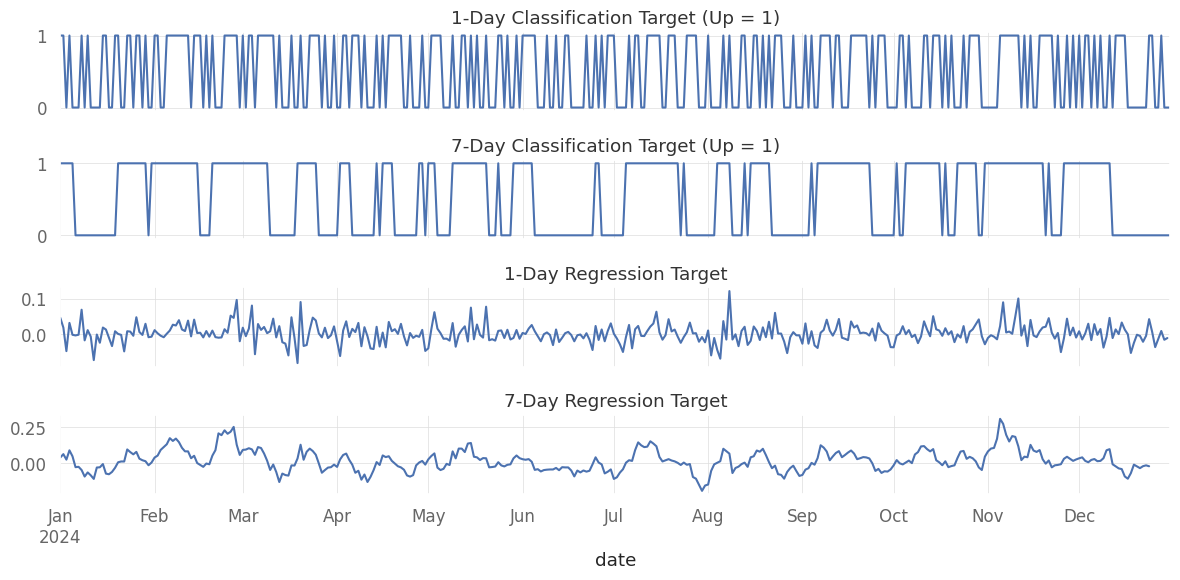

In [ ]:
# (Bitcoin (BTC)) Target Labeling Exploration

btc_df = add_target(btc_df, horizon=1, classification=True)
btc_df = add_target(btc_df, horizon=7, classification=True)
btc_df = add_target(btc_df, horizon=1, classification=False)
btc_df = add_target(btc_df, horizon=7, classification=False)

btc_df[['price',
         'target_class_1d', 'target_class_7d',
         'target_return_1d', 'target_return_7d']].dropna().head()

fig, axs = plt.subplots(4, 1, figsize=(12, 6), sharex=True)

btc_df['target_class_1d'].plot(ax=axs[0], title='1-Day Classification Target (Up = 1)')
btc_df['target_class_7d'].plot(ax=axs[1], title='7-Day Classification Target (Up = 1)')
btc_df['target_return_1d'].plot(ax=axs[2], title='1-Day Regression Target')
btc_df['target_return_7d'].plot(ax=axs[3], title='7-Day Regression Target')

plt.tight_layout()
plt.show()

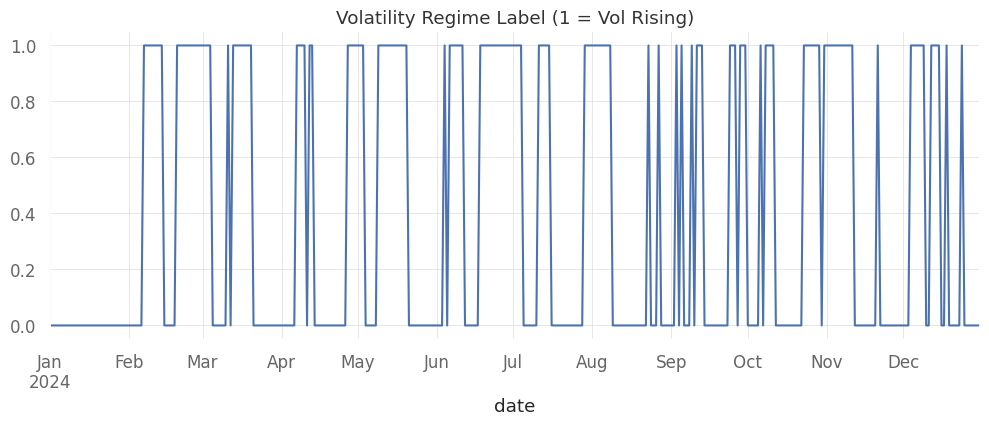

In [ ]:
btc_df = add_volatility_label(btc_df, 7) # weekly window
plt.figure(figsize=(12, 4))
btc_df['vol_label'].plot(title='Volatility Regime Label (1 = Vol Rising)')
plt.show()


**Model Training**

Trained a CatBoostRegressor. First was trained for Bitcoin 1D and 7D classification model to understand model behavior, then done for all coins using regression

In [ ]:
# A Bitcoin exploratory model training - 1D classification.

df = btc_df.dropna().copy()

target = 'target_class_1d'
features = [
    'return_1d', 'return_3d', 'return_7d',
    'volume_zscore', 'volatility_14d', 'rsi_14d',
    'macd', 'macd_signal', 'macd_diff',
    'bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_width'
]

split_index = int(len(df) * 0.7)

X_train = df.iloc[:split_index][features]
y_train = df.iloc[:split_index][target]
X_test = df.iloc[split_index:][features]
y_test = df.iloc[split_index:][target]

model = CatBoostClassifier(verbose=0, random_seed=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.4897959183673469
              precision    recall  f1-score   support

           0       0.47      0.80      0.60        46
           1       0.55      0.21      0.31        52

    accuracy                           0.49        98
   macro avg       0.51      0.51      0.45        98
weighted avg       0.51      0.49      0.44        98



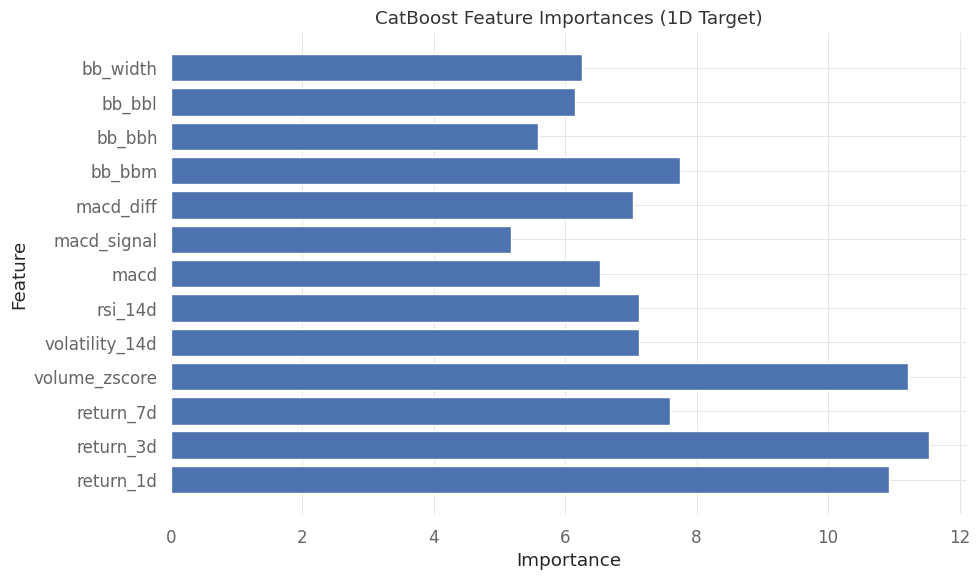

In [ ]:
#model above preformed poorly, but has a solid base. Below shows model feature importance for training information.

feature_importances = model.get_feature_importance()
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.title("CatBoost Feature Importances (1D Target)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
#comparison to 7D training - preformed worse.
df = btc_df.dropna().copy()

target = 'target_class_7d'

X_train = df.iloc[:split_index][features]
y_train = df.iloc[:split_index][target]

X_test = df.iloc[split_index:][features]
y_test = df.iloc[split_index:][target]

model_7d = CatBoostClassifier(verbose=0, random_seed=42)
model_7d.fit(X_train, y_train)

y_pred_7d = model_7d.predict(X_test)

print("Accuracy (7D):", accuracy_score(y_test, y_pred_7d))
print(classification_report(y_test, y_pred_7d))


Accuracy (7D): 0.3877551020408163
              precision    recall  f1-score   support

           0       0.33      0.76      0.46        34
           1       0.60      0.19      0.29        64

    accuracy                           0.39        98
   macro avg       0.47      0.48      0.38        98
weighted avg       0.51      0.39      0.35        98



**Hyperparameter tuning** to improve performace. We tested the following parameters:
1. depth: 4, 6, 8
2. learning rate: 0.01, 0.05, 0.1
3. l2 regularization: 1, 3, 5

The best results were depth of 8, learning rate of 0.01, and regularization of 5.


In [ ]:
df = multi_df.dropna().copy()

df['symbol'] = df['symbol'].astype('category')

features = [
    'return_1d', 'return_3d', 'return_7d',
    'volume_zscore', 'volatility_14d', 'rsi_14d',
    'macd', 'macd_signal', 'macd_diff',
    'bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_width',
    'symbol'
]

target = 'target_return_1d'

X = df[features].copy()
y = df[target]

split_index = int(len(X) * 0.7)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

best_score = float('inf')
best_model = None
best_params = {}

for depth in param_grid['depth']:
    for lr in param_grid['learning_rate']:
        for reg in param_grid['l2_leaf_reg']:
            print(f"Trying: depth={depth}, lr={lr}, l2={reg}")

            model = CatBoostRegressor(
                verbose=0,
                random_seed=42,
                cat_features=['symbol'],
                depth=depth,
                learning_rate=lr,
                l2_leaf_reg=reg
            )
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            mse = mean_squared_error(y_test, preds)
            r2 = r2_score(y_test, preds)

            print(f"→ MSE: {mse:.6f} | R²: {r2:.4f}")

            if mse < best_score:
                best_score = mse
                best_model = model
                best_params = {
                    'depth': depth,
                    'learning_rate': lr,
                    'l2_leaf_reg': reg
                }

print("\n Best Parameters Found:")
print(best_params)
print(f"Best MSE: {best_score:.6f}")

Trying: depth=4, lr=0.01, l2=1
→ MSE: 0.004107 | R²: 0.0267
Trying: depth=4, lr=0.01, l2=3
→ MSE: 0.004115 | R²: 0.0249
Trying: depth=4, lr=0.01, l2=5
→ MSE: 0.004105 | R²: 0.0271
Trying: depth=4, lr=0.05, l2=1
→ MSE: 0.004337 | R²: -0.0278
Trying: depth=4, lr=0.05, l2=3
→ MSE: 0.004263 | R²: -0.0102
Trying: depth=4, lr=0.05, l2=5
→ MSE: 0.004183 | R²: 0.0086
Trying: depth=4, lr=0.1, l2=1
→ MSE: 0.005007 | R²: -0.1865
Trying: depth=4, lr=0.1, l2=3
→ MSE: 0.004679 | R²: -0.1088
Trying: depth=4, lr=0.1, l2=5
→ MSE: 0.004547 | R²: -0.0776
Trying: depth=6, lr=0.01, l2=1
→ MSE: 0.004096 | R²: 0.0294
Trying: depth=6, lr=0.01, l2=3
→ MSE: 0.004085 | R²: 0.0320
Trying: depth=6, lr=0.01, l2=5
→ MSE: 0.004089 | R²: 0.0309
Trying: depth=6, lr=0.05, l2=1
→ MSE: 0.004357 | R²: -0.0325
Trying: depth=6, lr=0.05, l2=3
→ MSE: 0.004247 | R²: -0.0065
Trying: depth=6, lr=0.05, l2=5
→ MSE: 0.004260 | R²: -0.0096
Trying: depth=6, lr=0.1, l2=1
→ MSE: 0.004570 | R²: -0.0830
Trying: depth=6, lr=0.1, l2=3
→ MSE

<Axes: title={'center': 'Average Cumulative Returns: Strategy vs Market'}, xlabel='date'>

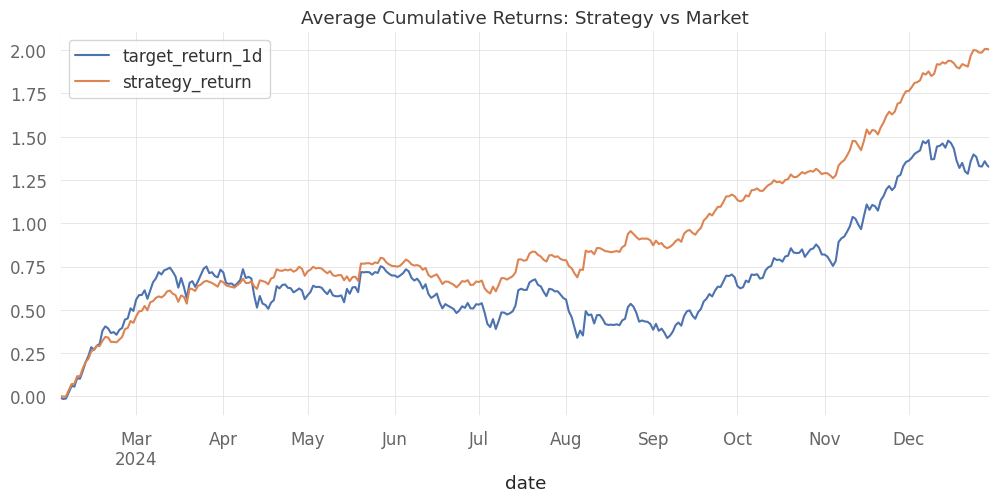

In [ ]:
#simulate and plot strategy based on predictions.

df_test = X_test.copy()
df_test['target_return_1d'] = y_test.values
df_test['predicted_return'] = best_model.predict(X_test)


df_test['strategy_return'] = (df_test['predicted_return'] > 0).astype(int) * df_test['target_return_1d']


df_test_grouped = df_test.groupby('date')[['target_return_1d', 'strategy_return']].mean()
df_test_grouped.cumsum().plot(
    figsize=(12, 5), title='Average Cumulative Returns: Strategy vs Market'
)



In [ ]:
!pip install shap
import shap

**SHAP Feature Interpretation**

We use SHAP to understand the marginal contribution of each feature to the model's predictions. This adds interpretability to our momentum model by showing which signals most consistently drive positive or negative predicted returns.

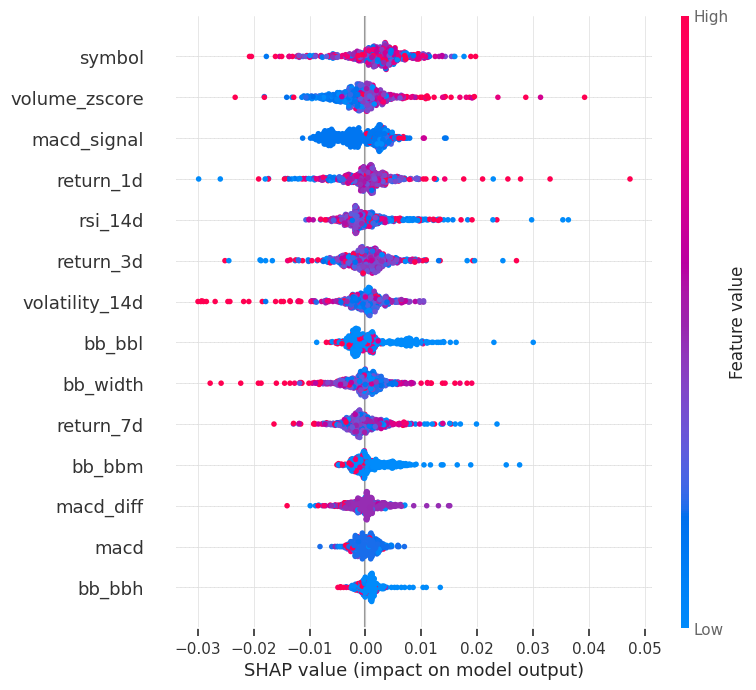

In [ ]:
X_shap = X_test.copy()
X_shap['symbol'] = X_shap['symbol'].cat.codes
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap.sample(n=500, random_state=42))
shap.summary_plot(shap_values, X_shap.sample(n=500, random_state=42))

**Backtesting**

The goal of this backtest is to simulate a simple long-only trading strategy using the model's predicted returns across multiple cryptocurrencies. We evaluate how this model-based strategy performs compared to the average daily market return (equal-weighted across all assets).


[Performance Metrics]



                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2024-08-01   2024-08-01
End Period          2024-12-30   2024-12-30
Risk-Free Rate      0.0%         0.0%
Time in Market      68.0%        100.0%

Cumulative Return   44.21%       222.48%
CAGR﹪              84.23%       605.71%

Sharpe              1.47         5.52
Prob. Sharpe Ratio  87.45%       100.0%
Sortino             2.38         13.37
Sortino/√2          1.68         9.45
Omega               2.59         2.59

Max Drawdown        -15.93%      -9.62%
Longest DD Days     31           20

Gain/Pain Ratio     0.35         1.59
Gain/Pain (1M)      4.5          -

Payoff Ratio        1.17         2.63
Profit Factor       1.35         2.59
Common Sense Ratio  2.0          5.61
CPC Index           0.84         3.95
Tail Ratio          1.48         2.16
Outlier Win Ratio   4.84         3.5
Outlier Loss Ratio  1.63         3.57

MTD                 -1.67%       26.02%
3M            

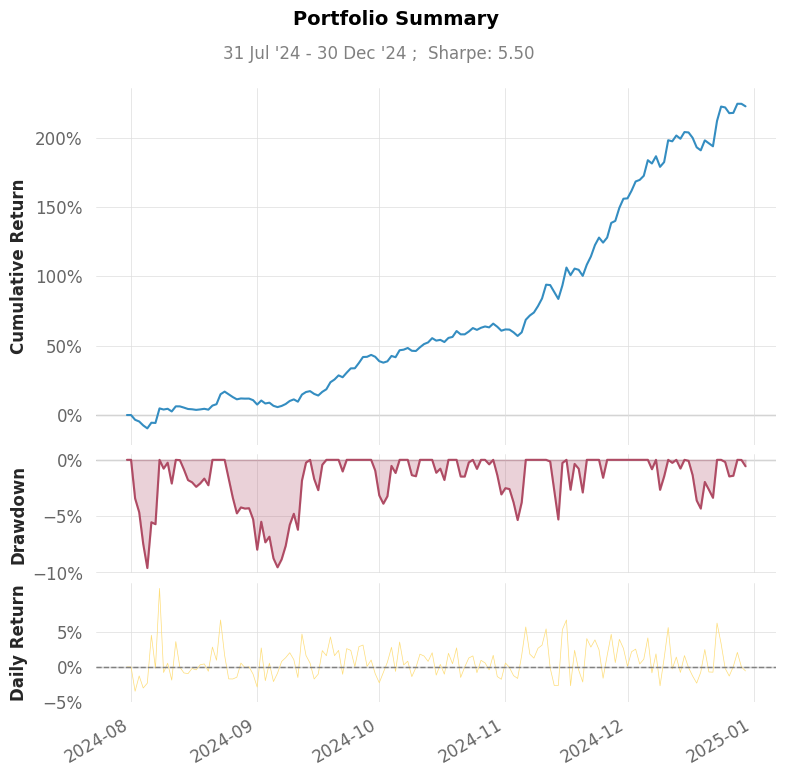

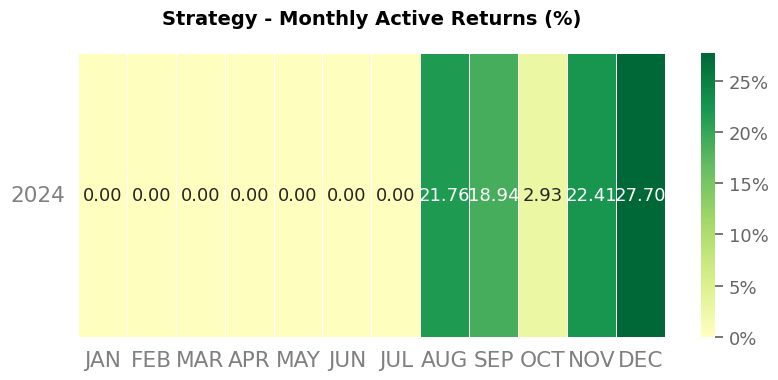

In [ ]:
daily_strategy = df_test.groupby('date')['strategy_return'].mean()

daily_strategy.index = pd.to_datetime(daily_strategy.index)
warnings.filterwarnings("ignore", module="matplotlib.font_manager")
qs.reports.basic(daily_strategy, benchmark='BTC')

**Key Findings**

Project Summary:

This project explored a momentum-based machine learning strategy for predicting short-term returns across the top 100 cryptocurrencies by market cap, using technical indicators and price-based features. The model was trained using walk-forward validation on daily data from 2024 and tuned using CatBoostRegressor with grid search.


Modeling Results:

- Model Type: CatBoostRegressor
- Prediction Target: 1-day forward return (target_return_1d)
- Input Features:
  - Returns (1D, 3D, 7D)
  - Volume Z-Score (30D)
  - Volatility (14D)
  - RSI (14D)
  - MACD (12/26/9)
  - Bollinger Bands (20D)
  - Symbol (categorical coin identifier)
- Best Hyperparameters:
  - depth: 8
  - learning_rate: 0.01
  - l2_leaf_reg: 5
- Performance:
  - MSE: 0.0021
  - R² Score: 0.0445


Strategy Backtest Highlights

- Strategy Cumulative Return: 222.48%
- Sharpe Ratio: 5.52
- CAGR: 605.71%
- Max Drawdown: -9.62%
- Time in Market: 100%
- Benchmark (BTC) Return: 44.21%
- Tool used: `QuantStats`


Feature Importance Insights

- Top predictive signals (SHAP):
  - RSI 14D
  - Volatility 14D
  - Return 1D
  - MACD line
  - Bollinger Band width

These indicators consistently contributed to upward or downward momentum predictions.